In [954]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from geopy import distance
import os
from sklearn.linear_model import Ridge

In [955]:
training = pd.read_csv("Train.csv")
riders = pd.read_csv("Riders.csv")
testing = pd.read_csv("Test.csv")
submission = pd.read_csv("SampleSubmission.csv")
variables = pd.read_csv("VariableDefinitions.csv")

In [956]:
train_riders = training.copy()
test_riders  = testing.copy()


In [957]:
train_riders = train_riders.merge(riders, how='left', on='Rider Id')
test_riders  = test_riders.merge(riders, how='left', on='Rider Id')
print('train without riders: ', training.shape)
print('train merged with riders: ', train_riders.shape)
print('---------------------------------------')
print('test without riders: ', testing.shape)
print('test merged with riders: ', test_riders.shape)


train without riders:  (21201, 29)
train merged with riders:  (21201, 33)
---------------------------------------
test without riders:  (7068, 25)
test merged with riders:  (7068, 29)


In [958]:
train_riders.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [959]:
train_riders.isnull().sum() / train_riders.shape[0] * 100.00


Order No                                      0.000000
User Id                                       0.000000
Vehicle Type                                  0.000000
Platform Type                                 0.000000
Personal or Business                          0.000000
Placement - Day of Month                      0.000000
Placement - Weekday (Mo = 1)                  0.000000
Placement - Time                              0.000000
Confirmation - Day of Month                   0.000000
Confirmation - Weekday (Mo = 1)               0.000000
Confirmation - Time                           0.000000
Arrival at Pickup - Day of Month              0.000000
Arrival at Pickup - Weekday (Mo = 1)          0.000000
Arrival at Pickup - Time                      0.000000
Pickup - Day of Month                         0.000000
Pickup - Weekday (Mo = 1)                     0.000000
Pickup - Time                                 0.000000
Arrival at Destination - Day of Month         0.000000
Arrival at

In [960]:
mean_temp = train_riders.Temperature.mean()
train_riders.Temperature.fillna(value=mean_temp,inplace=True)
test_riders.Temperature.fillna(value=mean_temp,inplace=True)

train_riders.drop(columns=["Precipitation in millimeters"],inplace=True)
test_riders.drop(columns=["Precipitation in millimeters"],inplace=True)

In [961]:
train_riders.dtypes

Order No                                      object
User Id                                       object
Vehicle Type                                  object
Platform Type                                  int64
Personal or Business                          object
Placement - Day of Month                       int64
Placement - Weekday (Mo = 1)                   int64
Placement - Time                              object
Confirmation - Day of Month                    int64
Confirmation - Weekday (Mo = 1)                int64
Confirmation - Time                           object
Arrival at Pickup - Day of Month               int64
Arrival at Pickup - Weekday (Mo = 1)           int64
Arrival at Pickup - Time                      object
Pickup - Day of Month                          int64
Pickup - Weekday (Mo = 1)                      int64
Pickup - Time                                 object
Arrival at Destination - Day of Month          int64
Arrival at Destination - Weekday (Mo = 1)     

#change  data Types 

In [962]:
from pandas.api.types import is_numeric_dtype
def change_types(df):
    int_to_float_columns = ["Time from Pickup to Arrival","Distance (KM)"]
    for column in df.columns:
        if(not is_numeric_dtype(df[column])):
            df[column] = df[column].astype("category")
        elif(np.issubdtype(df[column], np.int64) and column not in int_to_float_columns):
            df[column] = df[column].astype("category")
        elif(column in int_to_float_columns):
            df[column] = df[column].astype("float")

In [963]:
change_types(train_riders)
change_types(test_riders)

In [964]:
train_riders['Pickup - Time'] = pd.to_datetime(train_riders['Pickup - Time'])
train_riders['Arrival at Destination - Time'] = pd.to_datetime(train_riders['Arrival at Destination - Time'])
train_riders['Arrival at Pickup - Time'] = pd.to_datetime(train_riders['Arrival at Pickup - Time'])
train_riders['Placement - Time'] = pd.to_datetime(train_riders['Placement - Time'])






In [965]:
train_riders.dtypes

Order No                                           category
User Id                                            category
Vehicle Type                                       category
Platform Type                                      category
Personal or Business                               category
Placement - Day of Month                           category
Placement - Weekday (Mo = 1)                       category
Placement - Time                             datetime64[ns]
Confirmation - Day of Month                        category
Confirmation - Weekday (Mo = 1)                    category
Confirmation - Time                                category
Arrival at Pickup - Day of Month                   category
Arrival at Pickup - Weekday (Mo = 1)               category
Arrival at Pickup - Time                     datetime64[ns]
Pickup - Day of Month                              category
Pickup - Weekday (Mo = 1)                          category
Pickup - Time                           

##EDA

Text(0.5, 1.0, 'The distribution of the trip Duration distribution')

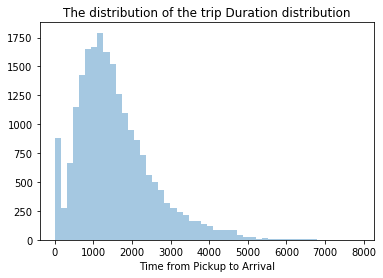

In [966]:
sns.distplot(train_riders['Time from Pickup to Arrival'],kde=False)
plt.title('The distribution of the trip Duration distribution')

In [967]:
train_riders["Time from Pickup to Arrival"].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

In [968]:
(train_riders["Arrival at Destination - Time"] - train_riders["Pickup - Time"]).describe()

count                     21201
mean     0 days 00:25:56.920947
std      0 days 00:16:27.270787
min             0 days 00:00:01
25%             0 days 00:14:42
50%             0 days 00:22:49
75%             0 days 00:34:00
max             0 days 02:11:23
dtype: object

##Most of our trips take between  22 minutes and 2 hours .
##There are several suspiciously short rides with less than 10 seconds duration.
##

##extraction the hour, minute and second features 

In [969]:
time = ['Arrival at Pickup - Time', 'Pickup - Time']

for c in time:
    print(c)
     #extracting the hour
    train_riders[c+'Hour'] = pd.to_datetime(training[c]).dt.hour
    test_riders[c+'Hour'] = pd.to_datetime(testing[c]).dt.hour
     #extracting the minutes
    train_riders[c+'minutes'] = pd.to_datetime(training[c]).dt.minute
    test_riders[c+'minutes'] = pd.to_datetime(testing[c]).dt.minute
     #extracting the seconds
    train_riders[c+'seconds'] = pd.to_datetime(training[c]).dt.second
    test_riders[c+'seconds'] = pd.to_datetime(testing[c]).dt.second

Arrival at Pickup - Time
Pickup - Time


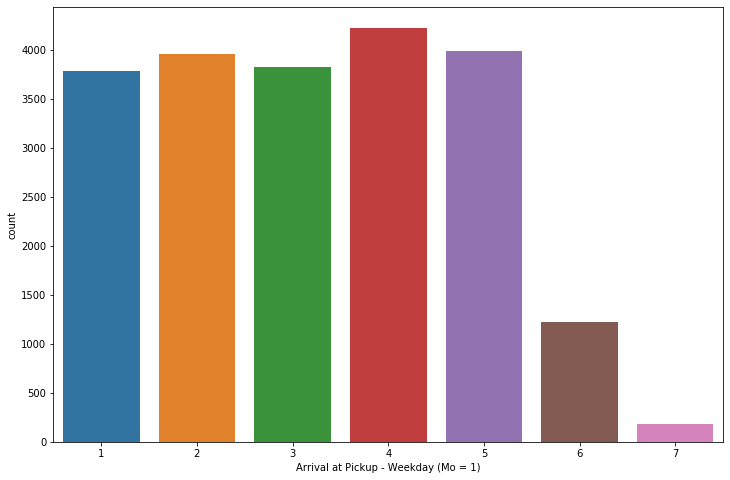

In [970]:
plt.figure(figsize=(12,8))
sns.countplot(x="Arrival at Pickup - Weekday (Mo = 1)", data=train_riders)
plt.show()

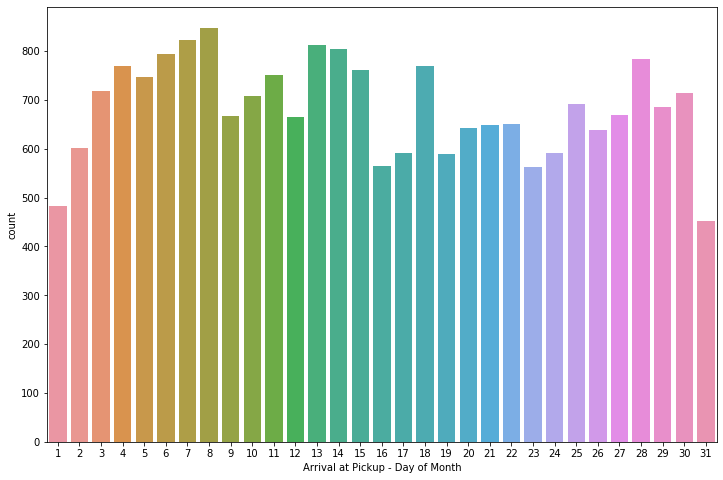

In [971]:
plt.figure(figsize=(12,8))
sns.countplot(x="Arrival at Pickup - Day of Month", data=train_riders)
plt.show()

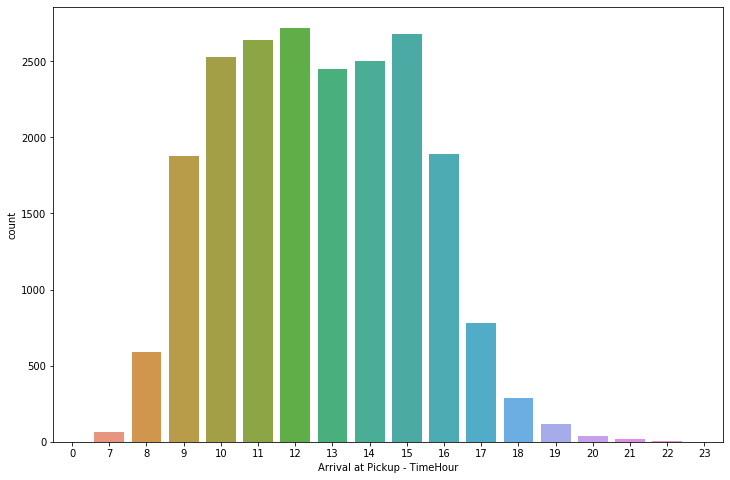

In [972]:
plt.figure(figsize=(12,8))
sns.countplot(x="Arrival at Pickup - TimeHour", data=train_riders)
plt.show()

#relationship between each of the variables with the target variable trip_duration.

C:\Users\Azukile\anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


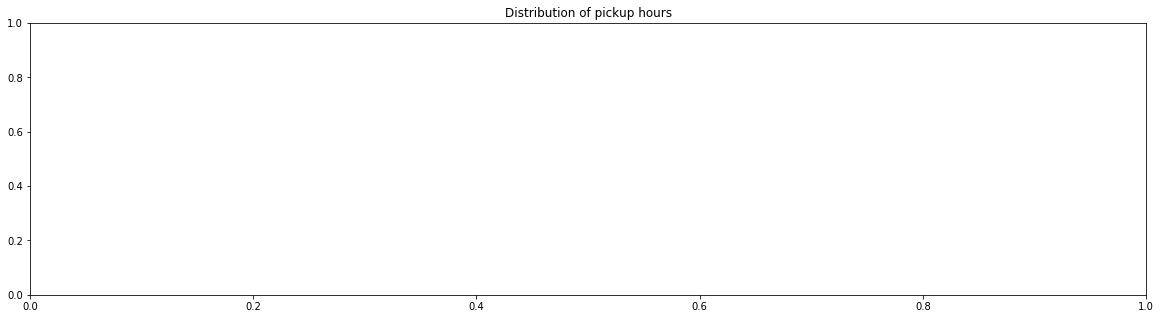

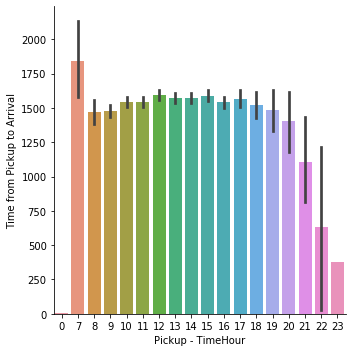

In [973]:
figure,(ax1)=plt.subplots(ncols=1,figsize=(20,5))
ax1.set_title('Distribution of pickup hours')
ax=sns.catplot(x="Pickup - TimeHour", y="Time from Pickup to Arrival",kind="bar",data=train_riders,ax=ax1)


##The highest average time taken to complete a trip are for trips started in the morning  and the least are the ones taken in the aftetrnoon

#The relationship between Distance  and trip duration 

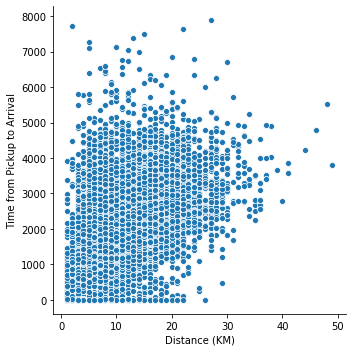

In [974]:
sns.relplot(x="Distance (KM)", y="Time from Pickup to Arrival", data=train_riders, kind="scatter")

In [975]:
#we have trips wich are in less than 20 Km distance but have take more than 5000 seconds to  this may be the indication some outliers 


###Converting Datatypes 

In [976]:
train_riders = train_riders.astype({"Rider Id":"category","Age":"float","No_Of_Orders":"float","No_of_Ratings":"float","Average_Rating":"float"},copy=False)
test_riders = test_riders.astype({"Rider Id":"category","Age":"float","No_Of_Orders":"float","No_of_Ratings":"float","Average_Rating":"float"},copy=False)

In [977]:
#Let us change convert age from days to years and Months 
train_riders['Age_Year'] = train_riders['Age']/365
train_riders['Age_Month'] = train_riders['Age']/30
train_riders['Age_Year']=round(train_riders['Age_Year'])
train_riders['Age_Month'] = round(train_riders['Age_Month'])
test_riders['Age_Year'] = test_riders['Age']/365
test_riders['Age_Month'] = test_riders['Age']/30
test_riders['Age_Year']=round(test_riders['Age_Year'])
test_riders['Age_Month'] = round(test_riders['Age_Month'])

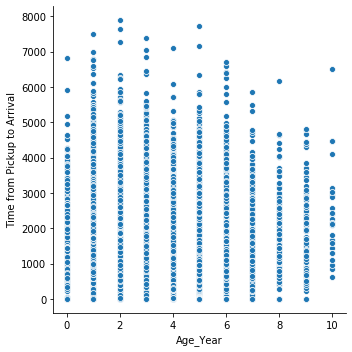

In [978]:
sns.relplot(x="Age_Year", y="Time from Pickup to Arrival", data=train_riders, kind="scatter")

#More exprienced drivers tend to Take reach the destination in less time than those who are less exprienced

#lets create 

In [979]:
train_riders.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Time from Pickup to Arrival', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings', 'Arrival at Pickup - TimeHour',
       'Arrival at Pickup - Timeminutes', 'Arrival at Pickup - Timeseconds',
       'Pickup - TimeHour', 'Pickup - Timeminutes', 'Pic

##Dropping not so usefull columns 

In [980]:
columns_to_drop = [
       'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)',
       'Placement - Time', 'Confirmation - Day of Month',
       'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time',
       'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time','Vehicle Type',
        ]                                                     

train_riders.drop(columns=columns_to_drop, inplace=True)
test_riders.drop(columns=columns_to_drop, inplace=True)

In [981]:
train_riders['Time_from_Pickup_to_Arrival_Minutes'] = train_riders['Time from Pickup to Arrival']/60
test_riders['Time_from_Pickup_to_Arrival_Minutes'] = train_riders['Time from Pickup to Arrival']/60

In [982]:
train_riders['speed']=train_riders['Distance (KM)']/train_riders['Time_from_Pickup_to_Arrival_Minutes']
test_riders['speed']=test_riders['Distance (KM)']/train_riders['Time_from_Pickup_to_Arrival_Minutes']


In [983]:
def compute_distance(row):
    src = (row["Pickup Lat"],row["Pickup Long"])
    dest= (row["Destination Lat"],row["Destination Long"])
    return distance.distance(src,dest).km

In [984]:
train_riders["geopy_distance"] = train_riders.apply(compute_distance,axis=1)
test_riders["geopy_distance"] = test_riders.apply(compute_distance,axis=1)

In [985]:
train_riders["Distance mean"] = (train_riders["Distance (KM)"] + train_riders["geopy_distance"])/2
test_riders["Distance mean"] = (test_riders["Distance (KM)"] + test_riders["geopy_distance"])/2

In [986]:
train_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Order No                                   21201 non-null  category      
 1   User Id                                    21201 non-null  category      
 2   Platform Type                              21201 non-null  category      
 3   Personal or Business                       21201 non-null  category      
 4   Pickup - Day of Month                      21201 non-null  category      
 5   Pickup - Weekday (Mo = 1)                  21201 non-null  category      
 6   Pickup - Time                              21201 non-null  datetime64[ns]
 7   Arrival at Destination - Day of Month      21201 non-null  category      
 8   Arrival at Destination - Weekday (Mo = 1)  21201 non-null  category      
 9   Arrival at Destin

In [987]:
list(zip( range(0,len(train_riders.columns)),train_riders.columns))

[(0, 'Order No'),
 (1, 'User Id'),
 (2, 'Platform Type'),
 (3, 'Personal or Business'),
 (4, 'Pickup - Day of Month'),
 (5, 'Pickup - Weekday (Mo = 1)'),
 (6, 'Pickup - Time'),
 (7, 'Arrival at Destination - Day of Month'),
 (8, 'Arrival at Destination - Weekday (Mo = 1)'),
 (9, 'Arrival at Destination - Time'),
 (10, 'Distance (KM)'),
 (11, 'Temperature'),
 (12, 'Pickup Lat'),
 (13, 'Pickup Long'),
 (14, 'Destination Lat'),
 (15, 'Destination Long'),
 (16, 'Rider Id'),
 (17, 'Time from Pickup to Arrival'),
 (18, 'No_Of_Orders'),
 (19, 'Age'),
 (20, 'Average_Rating'),
 (21, 'No_of_Ratings'),
 (22, 'Arrival at Pickup - TimeHour'),
 (23, 'Arrival at Pickup - Timeminutes'),
 (24, 'Arrival at Pickup - Timeseconds'),
 (25, 'Pickup - TimeHour'),
 (26, 'Pickup - Timeminutes'),
 (27, 'Pickup - Timeseconds'),
 (28, 'Age_Year'),
 (29, 'Age_Month'),
 (30, 'Time_from_Pickup_to_Arrival_Minutes'),
 (31, 'speed'),
 (32, 'geopy_distance'),
 (33, 'Distance mean')]

In [988]:
# Find all correlations and sort 
correlations_data = train_riders.corr()['Time from Pickup to Arrival'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(20))

speed                             -0.188162
Destination Lat                   -0.061872
Pickup Lat                        -0.053823
Average_Rating                    -0.042559
No_Of_Orders                      -0.041608
Age_Year                          -0.009171
Age                               -0.007969
Age_Month                         -0.007843
Arrival at Pickup - Timeseconds   -0.002916
Pickup - Timeseconds              -0.000473
No_of_Ratings                      0.005609
Temperature                        0.005772
Arrival at Pickup - Timeminutes    0.010009
Pickup - TimeHour                  0.010314
Pickup - Timeminutes               0.012259
Name: Time from Pickup to Arrival, dtype: float64 

Average_Rating                        -0.042559
No_Of_Orders                          -0.041608
Age_Year                              -0.009171
Age                                   -0.007969
Age_Month                             -0.007843
Arrival at Pickup - Timeseconds       -0.002916


In [989]:
numeric_subset = train_riders.select_dtypes('number')
categorical_subset = train_riders[['Personal or Business', 'Platform Type']]


categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features = features.dropna(subset = ['Time from Pickup to Arrival'])
correlations = features.corr()['Time from Pickup to Arrival'].dropna().sort_values()


In [990]:
train_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Order No                                   21201 non-null  category      
 1   User Id                                    21201 non-null  category      
 2   Platform Type                              21201 non-null  category      
 3   Personal or Business                       21201 non-null  category      
 4   Pickup - Day of Month                      21201 non-null  category      
 5   Pickup - Weekday (Mo = 1)                  21201 non-null  category      
 6   Pickup - Time                              21201 non-null  datetime64[ns]
 7   Arrival at Destination - Day of Month      21201 non-null  category      
 8   Arrival at Destination - Weekday (Mo = 1)  21201 non-null  category      
 9   Arrival at Destin

In [991]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join('SampleSubmission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='Order_No')
    
    submission['Time from Pickup to Arrival'] = prediction
    submission.to_csv(filename)

In [992]:
feature_selection = ["Destination Long", "Pickup Long","Arrival at Pickup - TimeHour","No_of_Ratings",
                     "No_of_Ratings","speed","Age_Year","geopy_distance","Pickup - TimeHour","Distance mean"]

In [993]:
y = train_riders["Time from Pickup to Arrival"]
X = train_riders[feature_selection]

In [994]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X__train, X__test, y__train, y__test = train_test_split(X, y, random_state=50, test_size=0.2)

In [995]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X__train, y__train)
y_pred = lr.predict(X__test)

mean_squared_error(y__test, y_pred)

573124.0184263167

In [996]:
from sklearn.metrics import r2_score
r2_score(y__test,y_pred)

0.39695418204209454

In [997]:
print(np.sqrt(mean_squared_error(y__test,y_pred)))

757.0495481976835


In [998]:
print(y_pred)

[2134.43237371 1025.61722388 1642.01708891 ... 1487.45135254 1540.22238954
 1530.47199601]
